# Quantum Black Holes (Group 4) - Quantum Corrections
(Suzanne Parr)

In astronomy the only thing we can detect is light. Understanding how it behaves near massive objects is essential to our understanding of black holes as a known form of "dark matter". 

The research goal is to understand how quantum effects can cause slight corrections to the path of light rays and also massive particles - in the vicinity of black holes. We start with the Schwarzschild metric describing motion in a spacetime governed by general relativity. This metric predicts orbital precession (observed in the orbit of planet Mercury), light deflection (lensing), and time dilation for a particle moving near a massive object. 

Here we add quantum corrections to our Schwarzschild black hole model. The corrections are derived in a paper by Saeed Rastgoo and colleagues. Past researchers found they could weave uncertainty-inspired quantum physics in a Schwarzschild black hole and the interior would behave according to observation but the math breaks down where spacetime flattens i.e. in the asymptotic region. To rectify this the team borrows an idea from 'Loop Quantum Gravity', namely that quantum parameters (QM) are momentum-dependent. This leads to an improvement to the interior model, which also works when extrapolated out to a full spacetime.

In [4]:
# import code libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.integrate import solve_ivp
import sympy as sp
import OGRePy as gr
from IPython.display import display, Math

In [5]:
# assign r as a symbol
r = gr.sym('r', nonnegative=True)

# Improved Metric with Quantum Corrections

Here we define improved metric functions that work within the classical SC framework,

$$ ds^2 = - f(r) \, dt^2 + g(r) \, dr^2 + h(r) \left( d\theta^2 + \sin^2\theta \, d\phi^2 \right) $$

As with the SC metric the improved metric represents a static, spherically symmetric spacetime. Spherical symmetry means we can confine the direction of angular momentum to $\theta = \frac{\pi}{2}$ and the magnitude, defined as $L = h(r) \frac{d\phi}{d\lambda}$, is conserved. The metric is independent of 't' so energy, defined as, $E = f(r) \frac{dt}{d\lambda}$ is also conserved. If we integrate once we get expressions for $\dot{t}$, $\dot{r}^2$ and $\dot{\phi}$ in terms of the metric functions, the conserved quantities, E and L and $\epsilon$ (0 for null and 1 for time-like geodesics). If we re-arrange the radial component to isolate $E^2$ we can "read off" the Effective Potential,

$$V_{\text{eff}}(r) = f(r) \left( \frac{L^2}{h(r)} + \epsilon \right)$$

an expression that is comparable to Newtonian gravitational potential energy. Below we define the metric functions, Effective Potential, and Equations of Motion for the improved metric. We also get a new version of $\frac{dr}{d\lambda}$, 

$$\frac{dr}{d\lambda} = \left( \frac{1}{g(r)} \left( \frac{E^2}{f(r)} - \left( \epsilon + \frac{L^2}{h(r)} \right) \right) \right)^{\frac{1}{2}}$$


In [6]:
# block 1 - functions: Schwarzschild radius, quantum-corrected metric functions, effective potential and equations of motion.

# get schwarzschild radius from mass
def r_sc(M):
    return (2*M)

# schwarzschild metric functions (dependent on radial coordinate, r, SC radius and quantum corrections, Q_b, Q_c)
def f(r, M, Q_b, Q_c):
    return (1 + Q_b/r**2) * (1 + (Q_c*(2*M)**2)/(4*r**8))**(-1/4) * (1-(2*M)/(gr.s.sqrt(r**2+Q_b)))

def g(r, M, Q_b, Q_c):
    return (1 + (Q_c*(2*M)**2)/(4*r**8))**(1/4) * (1-(2*M)/(gr.s.sqrt(r**2+Q_b)))**(-1)

def h(r, M, Q_c):
    return r**2 * (1 + (Q_c*(2*M)**2)/(4*r**8))**(1/4)

# effective potential
def v_eff(r, M, L, Q_b, Q_c, epsilon=0):
    return f(r, M, Q_b, Q_c) * (L**2/h(r, M, Q_c) + epsilon)

# lamda can be replaced by tau for massive particles
def eq_of_motion(lamda, y, params, epsilon=0):

    t, r, phi = y
    E, L, M, Q_b, Q_c = params

    dt_dlamda = E / f(r, M, Q_b, Q_c)
    dphi_dlamda = L / h(r, M, Q_c)
    squared = 1/g(r, M, Q_b, Q_c) * (E**2 / f(r, M, Q_b, Q_c) - (epsilon + L**2 / h(r, M, Q_c)))
    dr_dlamda = gr.s.sqrt(max(squared, 0))  # *** ensure non-negative input; obtain real part instead? ***

    return [dt_dlamda, dr_dlamda, dphi_dlamda]

# Assign Values to Constants

Assign values for Mass (M) of central massive object, Angular momentum (L) of the orbiting particle, a test value of Energy (E) and a set of values for the quantum parameters (QM) to see how quantum effects change effective potential.

In [7]:
# block 2 - assign test values for mass, energy, and angular momentum
M1 = 1.0  
rs1 = r_sc(M1)
r1 = 10 * rs1
# test values of quantum parameters
Q_b0 = 0.0
Q_b1 = 0.25
Q_b2 = 0.5
Q_b3 = 0.75
Q_b4 = 1.0
Q_c0 = 0.0
Q_c1 = 0.25
Q_c2 = 0.5
Q_c3 = 0.75
Q_c4 = 1.0

# conserved quantities
# for SC and quantum Geodesics testing I will constrain L and see what happens when I vary total energy E of the particle and 
L1 = 3.8 # angular momentum of orbiting particle

# calculate and print SC metric components at a given radial distance from the BH, BH mass, and with Q_b = 0.5
f1 = f(r1, M1, Q_b2, Q_c0)
g1 = g(r1, M1, Q_b2, Q_c0)
h1 = h(r1, M1, Q_c0)

print(f"f(r) = {f1}")
print(f"g(r) = {g1}")
print(f"h(r) = {h1}")

f(r) = 0.901187519519053
g(r) = 1.11103402822794
h(r) = 400.0


# Effective Potential and Extrema

We find extrema by setting $\frac{dV_{\text{eff}}}{dr} = 0$ and solving for the (real) roots - values of 'r' where the slope of the effective potential is '0'.

In the case of light ($\epsilon = 0$) there is only a maximum at r = 3 * M when the quantum corrections (QM) = 0.

What follows is a function "find_extrema" that uses OGRePy's numerical function, nsolve to find the roots. For the case of light ($\epsilon = 0$) and a chosen value of angular momentum, L = 4.3 - a number that worked well - we can find the radial position, r, and value of $V_{\text{eff}}(r)$ at the maxima for a range of 13 $Q_b$ values between 0 and 1. Next "find_extrema" is run in a loop saving the $Q_b$ value and r, and $V_{\text{eff}}(r)$ values in an array for subsequent use in plotting trajectories. For this study we can ignore $Q_c$ (set it equal to 0) since $Q_b$ has a much larger effect and $Q_c$ is negligable by comparison. 

Finally we plot $V_{\text{eff}}(r)$ for L = 4.3 and at 13 $Q_b$ values with maximum potential (maxima) marked on the plot.

In [8]:
# block 3 - locate extrema for v_eff vs r (radial distance from a black hole). 
# extrema are found using OGRePy 'nsolve' numerically.
def find_extrema(M_val, L_val, Q_b_val, Q_c_val, eps_val, r_range):
    v_eff = f(r, M_val, Q_b_val, Q_c_val) * (L_val**2 / h(r, M_val, Q_c_val) + eps_val)

    # first derivative with respect to r
    dv_eff_dr = gr.s.diff(v_eff, r)
    # second derivative with respect to r
    d2v_eff_dr2 = gr.s.diff(dv_eff_dr, r)

    extrema = []
    # solve dv_eff_dr = 0 for a range of initial guesses
    for r_init in np.linspace(r_range[0], r_range[1], 50):
        try:
            root = gr.s.nsolve(dv_eff_dr, r, r_init)
            root = float(root)
            if not any(np.isclose(root, ext, atol=1e-6) for ext in extrema) and r_range[0] <= root <= r_range[1]:
                extrema.append(root) # ensure no "very close" extrema (tolerance of 10^-6); only pick values within the chosen r range. 
        except Exception:
            pass  # skip guess if nsolve fails

    extrema_results = []
    print(f"\nExtrema for ε = {eps_val}, M = {M1}, L = {L_val}, Q_b = {Q_b_val}, Q_c = {Q_c_val}:")
    for r_ex in extrema:
        v_eff_at_r = v_eff.subs(r, r_ex).evalf()  # evaluate symbolic function at values of r that rep extrema
        d2v_eff_dr2_r_ex = d2v_eff_dr2.subs(r, r_ex).evalf()  # 2nd derivative at extrema
        extrema_type = "min" if d2v_eff_dr2_r_ex > 0 else "max"
        extrema_results.append((r_ex, v_eff_at_r, extrema_type))
        print(f"r = {r_ex:.4f}, v_eff = {v_eff_at_r:.4f}, Type: {extrema_type}")

    return extrema_results, v_eff


Extrema for ε = 0, M = 1.0, L = 3.8, Q_b = 0.0, Q_c = 0.0:
r = 3.0000, v_eff = 0.5348, Type: max

Extrema for ε = 0, M = 1.0, L = 3.8, Q_b = 0.08333333333333333, Q_c = 0.0:
r = 2.9674, v_eff = 0.5449, Type: max

Extrema for ε = 0, M = 1.0, L = 3.8, Q_b = 0.16666666666666666, Q_c = 0.0:
r = 2.9345, v_eff = 0.5555, Type: max

Extrema for ε = 0, M = 1.0, L = 3.8, Q_b = 0.25, Q_c = 0.0:
r = 2.9012, v_eff = 0.5664, Type: max

Extrema for ε = 0, M = 1.0, L = 3.8, Q_b = 0.3333333333333333, Q_c = 0.0:
r = 2.8675, v_eff = 0.5779, Type: max

Extrema for ε = 0, M = 1.0, L = 3.8, Q_b = 0.41666666666666663, Q_c = 0.0:
r = 2.8334, v_eff = 0.5899, Type: max

Extrema for ε = 0, M = 1.0, L = 3.8, Q_b = 0.5, Q_c = 0.0:
r = 2.7989, v_eff = 0.6024, Type: max

Extrema for ε = 0, M = 1.0, L = 3.8, Q_b = 0.5833333333333333, Q_c = 0.0:
r = 2.7639, v_eff = 0.6155, Type: max

Extrema for ε = 0, M = 1.0, L = 3.8, Q_b = 0.6666666666666666, Q_c = 0.0:
r = 2.7286, v_eff = 0.6293, Type: max

Extrema for ε = 0, M = 

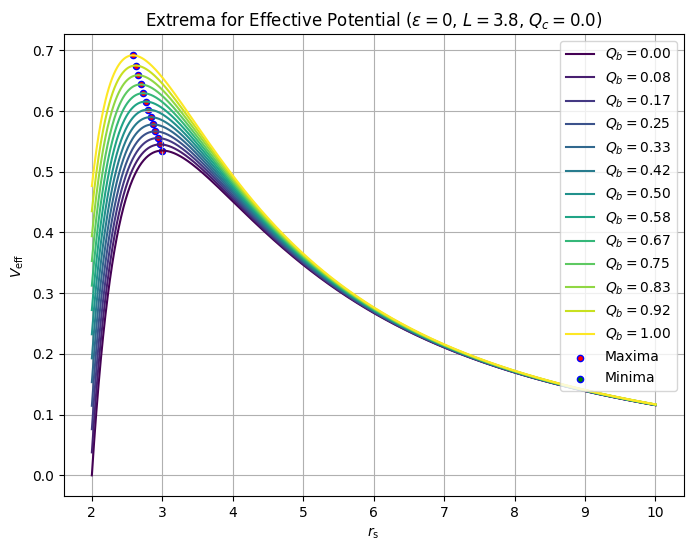

1st row of extrema data points (r, v_eff, Q_b, max/min):
[[3.0 0.534814814814815 0.0 'max']]


In [10]:
#block 4 - find v_eff max for different values of Q_b and create array for the results
r_range = (rs1, 5 * rs1)
eps = 0

Q_b_vals = np.linspace(0, 1.0, 13)
colors = plt.cm.viridis(np.linspace(0, 1, len(Q_b_vals)))
plt.figure(figsize=(8, 6))
max_x, max_y, min_x, min_y = [], [], [], []

# array to store extrema data: r, v_eff, Q_b
extrema_data = []

for Q_b, color in zip(Q_b_vals, colors):
    extrema, v_eff_func = find_extrema(M1, L1, Q_b, Q_c0, eps, r_range)
    r_vals1 = np.linspace(r_range[0], r_range[1], 1000)
    v_eff_func_num = sp.lambdify(r, v_eff_func, "numpy")
    v_eff_vals = v_eff_func_num(r_vals1)
    plt.plot(r_vals1, v_eff_vals, color=color, label=rf'$Q_b={Q_b:.2f}$')
    for r_ex, v_eff_at_r, ext_type in extrema:
        extrema_data.append((r_ex, v_eff_at_r, Q_b, ext_type))
        if ext_type == "max":
            max_x.append(r_ex)
            max_y.append(v_eff_at_r)
        else:
            min_x.append(r_ex)
            min_y.append(v_eff_at_r)

plt.scatter(max_x, max_y, color='r', s=20, edgecolors='b', label="Maxima")
plt.scatter(min_x, min_y, color='g', s=20, edgecolors='b', label="Minima")
plt.xlabel(r'$r_{\mathrm{s}}$')
plt.ylabel(r'$V_{\mathrm{eff}}$')
plt.title(rf"Extrema for Effective Potential ($\varepsilon={eps}$, $L={L1}$, $Q_c={Q_c0}$)")
plt.legend()
plt.grid(True)
plt.show()

# NumPy array with extrema data including: r, v_eff, Q_b val, extrema type
extrema_array = np.array(extrema_data)

# test print
print("1st row of extrema data points (r, v_eff, Q_b, max/min):")
print(extrema_array[:1])


In [11]:
# print v_eff max, Q_b value for 3 Q_b values: 0, 0.5, 1.0.
print(extrema_array[0, 0:3])
print(extrema_array[6, 0:3])
print(extrema_array[12, 0:3])

[3.0 0.534814814814815 0.0]
[2.798855056903118 0.602400344823144 0.5]
[2.5824368614246005 0.691685334114515 1.0]


# Orbits

In this approach we solve for $r(\lambda)$ and $\phi(\lambda)$ by integrating the equations of motion $\frac{dr}{d\lambda}$ and $\frac{d\phi}{d\lambda}$ with 'solve_ivp' and $\lambda$ as the independent variable. This results in a list of values which can be converted to cartesian coordinates to plot y(x). We can change direction of $\frac{dr}{d\lambda}$ to list values moving inwards or heading outwards. 

Next we learn the importance of extrema. What follows is the "energy equation" we get by substituting conserved entities, L and E into the equation for $\frac{dr}{d\lambda}$ and rearranging terms,

$$
f(r) g(r) \left(\frac{dr}{d\lambda} \right)^2 + f(r) \left(\frac{L^2}{h(r)} + \epsilon \right) = E^2
$$

The 1st term corresponds to kinetic energy and 2nd term corresponds to gravitational potential energy with total energy ($E^2$) on the right-hand side. At the turning points in a circular orbit radial velocity (therefore kinetic energy) equals zero and the total energy is 100% equal to potential energy.

In the following code block we define the solver function, 'solve_geodesic', then we set 5 sets of initial conditions (all for $Q_b$ = 0 or classical Schwarzschild metric), run the solver, and plot each trajectory together with a plot of $V_{\text{eff}}(r)$ beside it showing the relationship between effective potential and total energy.

In [12]:
# function for inward / outward integration
def solve_geo2(r_init, phi_init, t_init, lam_range, params, epsilon=0, direction='inward', stop_far_out=True, r_max=10):
    E, L, M, Q_b, Q_c = params
    sign = -1 if direction == 'inward' else 1
    flipped_on_this_neg = False

    # Check squared at the initial radius
    ff0 = float(f(r_init, M, Q_b, Q_c))
    gg0 = float(g(r_init, M, Q_b, Q_c))
    hh0 = float(h(r_init, M, Q_c))

    squared0 = (1/gg0) * (E**2 / ff0 - (epsilon + L**2 / hh0))
    print("Initial squared:", squared0)

    if squared0 < 0:
        print("Warning: Initial region is classically forbidden.")
        flipped_on_this_neg = True

    def dy_dt(lam, y):
        nonlocal sign, flipped_on_this_neg

        t, r, phi = y
        r = float(r)

        ff = float(f(r, M, Q_b, Q_c))
        gg = float(g(r, M, Q_b, Q_c))
        hh = float(h(r, M, Q_c))

        squared = (1/gg) * (E**2 / ff - (epsilon + L**2 / hh))

        if squared < 0 and not flipped_on_this_neg:
            sign *= -1
            flipped_on_this_neg = True
        elif squared >= 0:
            flipped_on_this_neg = False

        dt_dlam = E / ff
        dr_dlam = sign * np.sqrt(abs(squared))
        dphi_dlam = L / r**2

        return [dt_dlam, dr_dlam, dphi_dlam]

    def horizon_event(lam, y):
        return y[1] - (2 * M)
    horizon_event.terminal = True
    horizon_event.direction = -1  # detect crossing inward

    events = [horizon_event]

    if stop_far_out:
        def escape_event(lam, y):
            return y[1] - r_max
        escape_event.terminal = True
        escape_event.direction = 1  # detect escaping outward
        events.append(escape_event)

    sol = solve_ivp(
        dy_dt,
        lam_range,
        [t_init, r_init, phi_init],
        t_eval=np.linspace(*lam_range, 2000),
        atol=1e-6,
        rtol=1e-6,
        events=events,
        max_step=0.2
    )

    for i, event in enumerate(sol.t_events):
        if len(event) > 0:
            label = 'horizon' if i == 0 else f'event {i}'
            print(f"{label} triggered at λ = {event[0]:.4f}")

    t_vals = sol.y[0]
    r_vals = sol.y[1]
    phi_vals = np.unwrap(sol.y[2])

    return t_vals, r_vals, phi_vals



# Light Ray Paths for a classical Schwarzschild metric

For M = 1.0 and L = 3.8 there is a circular orbit at 3 * M exactly at the effective potential maxima. If our light ray begins a path outside 3 * M (lets say at 5 times $r_{\text{sc}}$) and travels inwards, the light ray will be scattered after a turning point, if it has energy less than the maximum potential or it will plunge into the BH with energy greater than the maximum potential. Conversely, if the light ray begins between $r_{\text{sc}}$ and 3 * M, say at 2.4 * M, it will escape with energy greater than the maximum potential and plunge into the black hole with energy less than the maximum potential.

Next: using the array of maxima for $V_{\text{eff}}(r)$ for different values of $Q_b$ we have the location for a perfect circular plot. We should see similar scattering and plunging situations but for shifted values of energy as compared to the classic SC metric. 

In [13]:
# block 6 - create data for light trajectories 
# ------- classic schwarzschild case (Qb=0) ------ #
Qc0 = 0.0
phi0 = 0
t0 = 0
lam_range_1 = [0, 30]
lam_range_2 = [0, 50]
lam_range_3 = [0, 80]
r0 = 5 * rs1 # far out starting point
r_in1 = 2.2 * M1 # inside v_max starting point
Qb0 = float(extrema_array[0, 2])
r_circ1 = float(extrema_array[0, 0])
r_near1 = r_circ1 + 0.2
E0_sq1 = float(extrema_array[0, 1])
E0_1 = np.sqrt(E0_sq1) #v_eff at max (= E^2)
#----------- circular orbit
params1 = (E0_1, L1, M1, Qb0, Qc0)

r_vals1 = np.linspace(rs1, 5*rs1, 1000)
v_eff1 = np.array([v_eff(i, M1, L1, Qb0, Qc0, epsilon=0) for i in r_vals1])

t_vals_1, r_vals_1, phi_vals_1 = solve_geo2(r_near1, phi0, t0, lam_range_2, params1, epsilon=0)

# cartesian coordinates
x_vals_1 = r_vals_1 * np.cos(phi_vals_1)
y_vals_1 = r_vals_1 * np.sin(phi_vals_1)

#---------- E greater than circular -------------
E0_sq2 = E0_sq1 + 0.10
E0_2 = np.sqrt(E0_sq2)
params2 = (E0_2, L1, M1, Qb0, Qc0)

t_vals_2, r_vals_2, phi_vals_2 = solve_geo2(r0, phi0, t0, lam_range_2, params2, epsilon=0)

# cartesian coordinates
x_vals_2 = r_vals_2 * np.cos(phi_vals_2)
y_vals_2 = r_vals_2 * np.sin(phi_vals_2)

#---------- E less than circular -------------
E0_sq3 = E0_sq1 - 0.10
E0_3 = np.sqrt(E0_sq3)
params3 = (E0_3, L1, M1, Qb0, Qc0)

t_vals_3, r_vals_3, phi_vals_3 = solve_geo2(r0, phi0, t0, lam_range_2, params3, epsilon=0)

# cartesian coordinates
x_vals_3 = r_vals_3 * np.cos(phi_vals_3)
y_vals_3 = r_vals_3 * np.sin(phi_vals_3)

#---------- From inside - E greater than circular -------------
E0_sq4 = E0_sq1 + 0.10
E0_4 = np.sqrt(E0_sq4)
params4 = (E0_4, L1, M1, Qb0, Qc0)

t_vals_4, r_vals_4, phi_vals_4 = solve_geo2(r_in1, phi0, t0, lam_range_1, params4, epsilon=0, direction='outward')

# cartesian coordinates
x_vals_4 = r_vals_4 * np.cos(phi_vals_4)
y_vals_4 = r_vals_4 * np.sin(phi_vals_4)

#---------- From inside - E less than circular -------------
E0_sq5 = E0_sq1 - 0.10
E0_5 = np.sqrt(E0_sq5)
params5 = (E0_5, L1, M1, Qb0, Qc0)

t_vals_5, r_vals_5, phi_vals_5 = solve_geo2(r_in1, phi0, t0, lam_range_1, params5, epsilon=0)

# cartesian coordinates
x_vals_5 = r_vals_5 * np.cos(phi_vals_5)
y_vals_5 = r_vals_5 * np.sin(phi_vals_5)
#---------------------------


Initial squared: 0.006006221064814965
Initial squared: 0.5192948148148149
Initial squared: 0.31929481481481486
event 1 triggered at λ = 32.6722
Initial squared: 0.3635901716893452
event 1 triggered at λ = 14.5698
Initial squared: 0.16359017168934517


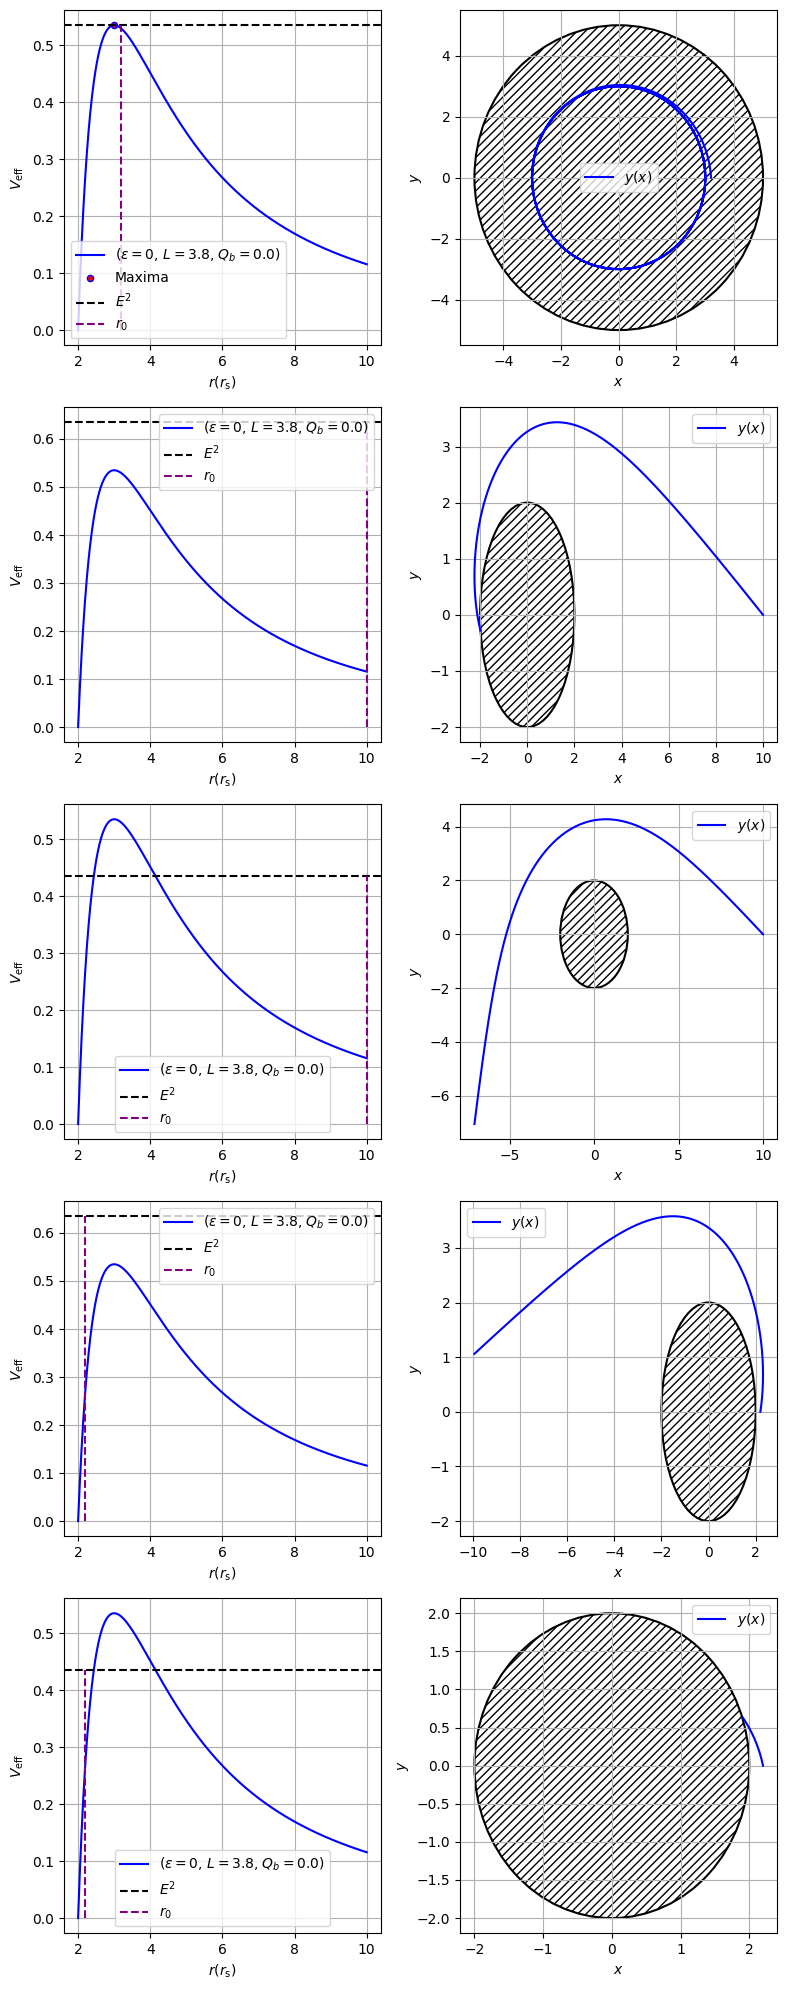

In [ ]:
# block 7 - plot light trajectories - 5 initial conditions (r0, E)
# ------ classic schwarzschild case (Qb = 0) -----#
fig, axes = plt.subplots(5, 2, figsize=(8, 20))

# First plot
axes[0, 0].plot(r_vals1, v_eff1, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb0}$)", color='b')
axes[0, 0].scatter(extrema_array[0,0], extrema_array[0,1], color='r', s=20, edgecolors='b', label="Maxima")
axes[0, 0].axhline(y=E0_sq1, color='black', linestyle='--', label=r'$E^2$')
axes[0, 0].vlines(x=r_near1, ymin=min(v_eff1), ymax=E0_sq1, color='purple', linestyle='--', label=r'$r_0$')
axes[0, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[0, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[0, 0].legend()
axes[0, 0].grid()

# Second plot
axes[0, 1].plot(x_vals_1, y_vals_1, label=r'$y(x)$', color='blue')
circle_1 = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[0, 1].add_patch(circle_1)
axes[0, 1].set_xlabel(r'$x$')
axes[0, 1].set_ylabel(r'$y$')
axes[0, 1].legend()
axes[0, 1].grid()

# Third plot
axes[1, 0].plot(r_vals1, v_eff1, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb0}$)", color='b')
axes[1, 0].axhline(y=E0_sq2, color='black', linestyle='--', label=r'$E^2$')
axes[1, 0].vlines(x=r0, ymin=min(v_eff1), ymax=E0_sq2, color='purple', linestyle='--', label=r'$r_0$')
axes[1, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[1, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[1, 0].legend()
axes[1, 0].grid()

# Fourth plot
axes[1, 1].plot(x_vals_2, y_vals_2, label=r'$y(x)$', color='blue')
circle_2 = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[1, 1].add_patch(circle_2)
axes[1, 1].set_xlabel(r'$x$')
axes[1, 1].set_ylabel(r'$y$')
axes[1, 1].legend()
axes[1, 1].grid()

# Fifth plot
axes[2, 0].plot(r_vals1, v_eff1, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb0}$)", color='b')
axes[2, 0].axhline(y=E0_sq3, color='black', linestyle='--', label=r'$E^2$')
axes[2, 0].vlines(x=r0, ymin=min(v_eff1), ymax=E0_sq3, color='purple', linestyle='--', label=r'$r_0$')
axes[2, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[2, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[2, 0].legend()
axes[2, 0].grid()

# 6th plot
axes[2, 1].plot(x_vals_3, y_vals_3, label=r'$y(x)$', color='blue')
circle_3 = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[2, 1].add_patch(circle_3)
axes[2, 1].set_xlabel(r'$x$')
axes[2, 1].set_ylabel(r'$y$')
axes[2, 1].legend()
axes[2, 1].grid()

# 7th plot
axes[3, 0].plot(r_vals1, v_eff1, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb0}$)", color='b')
axes[3, 0].axhline(y=E0_sq4, color='black', linestyle='--', label=r'$E^2$')
axes[3, 0].vlines(x=r_in1, ymin=min(v_eff1), ymax=E0_sq4, color='purple', linestyle='--', label=r'$r_0$')
axes[3, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[3, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[3, 0].legend()
axes[3, 0].grid()

# 8th plot
axes[3, 1].plot(x_vals_4, y_vals_4, label=r'$y(x)$', color='blue')
circle_4 = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[3, 1].add_patch(circle_4)
axes[3, 1].set_xlabel(r'$x$')
axes[3, 1].set_ylabel(r'$y$')
axes[3, 1].legend()
axes[3, 1].grid()

# 9th plot
axes[4, 0].plot(r_vals1, v_eff1, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb0}$)", color='b')
axes[4, 0].axhline(y=E0_sq5, color='black', linestyle='--', label=r'$E^2$')
axes[4, 0].vlines(x=r_in1, ymin=min(v_eff1), ymax=E0_sq5, color='purple', linestyle='--', label=r'$r_0$')
axes[4, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[4, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[4, 0].legend()
axes[4, 0].grid()

# 10th plot
axes[4, 1].plot(x_vals_5, y_vals_5, label=r'$y(x)$', color='blue')
circle_5 = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[4, 1].add_patch(circle_5)
axes[4, 1].set_xlabel(r'$x$')
axes[4, 1].set_ylabel(r'$y$')
axes[4, 1].legend()
axes[4, 1].grid()

plt.tight_layout()
plt.show()

Initial squared: 0.007275309426616486
Initial squared: 0.5833138853712099
horizon triggered at λ = 14.3246
Initial squared: 0.38430891024683195
event 1 triggered at λ = 31.2288
Initial squared: 0.2353098510222178
event 1 triggered at λ = 13.9655
Initial squared: 0.05403644278251755
horizon triggered at λ = 0.5757


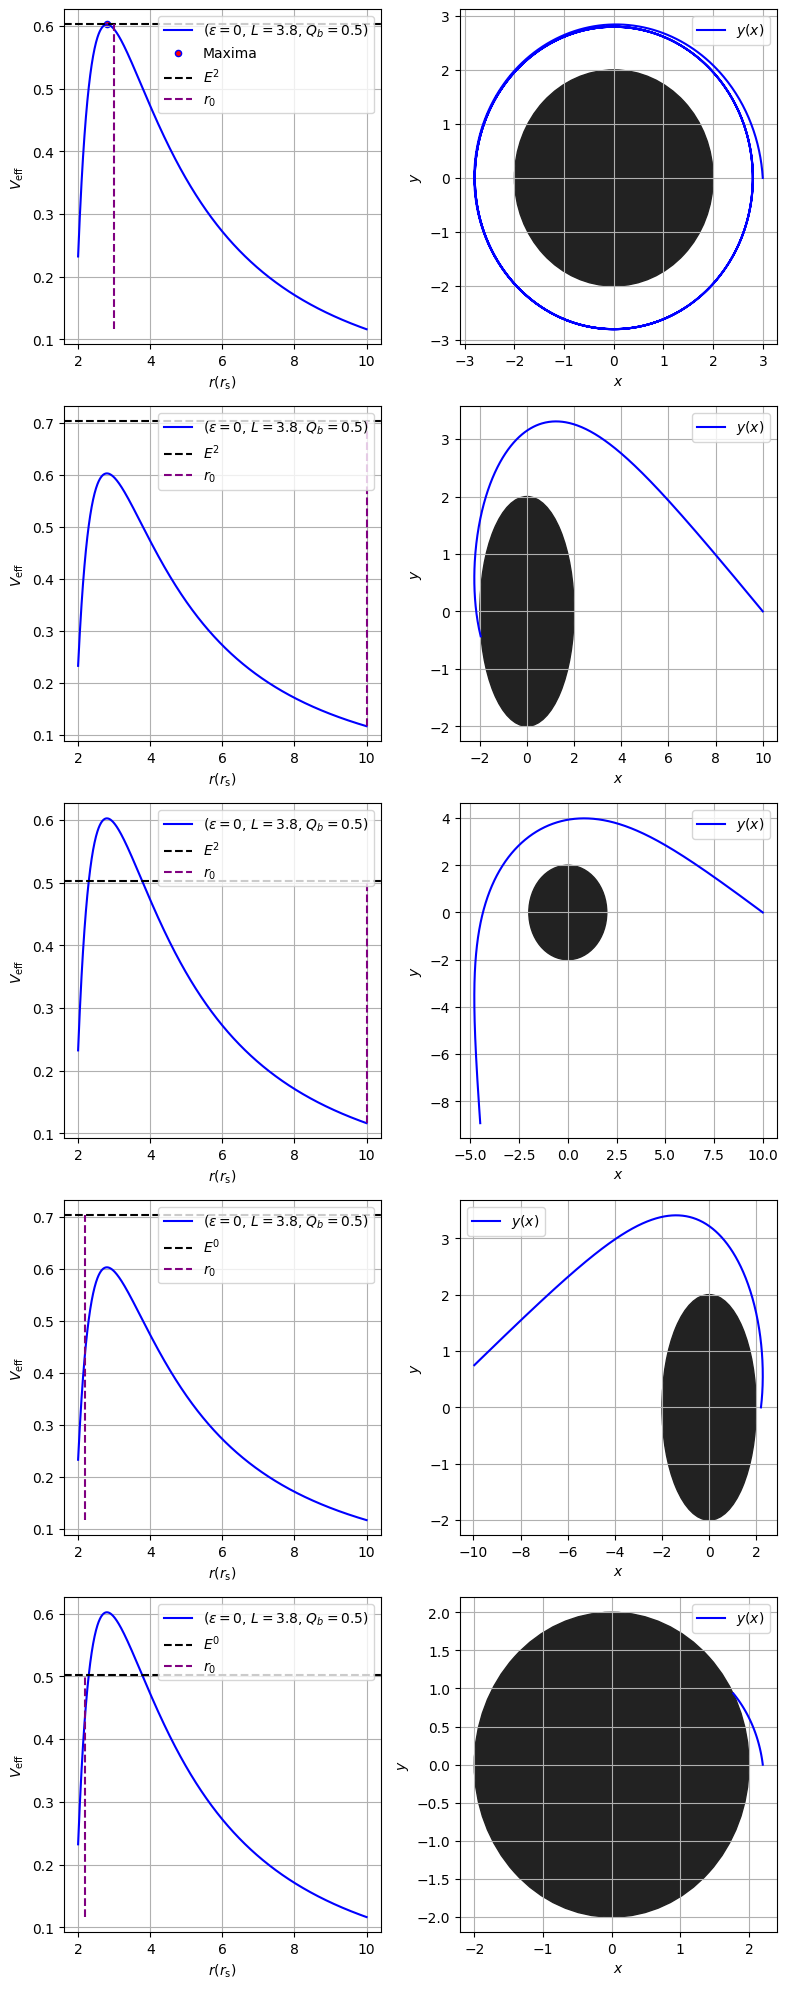

In [ ]:
# block 8 - create data for light trajectories 
# ------- with quantum corrections (Qb = 0.5) ------ #
Qb1 = float(extrema_array[6, 2])
r_circ2 = float(extrema_array[6, 0])
r_near2 = r_circ2 + 0.2
r_in2 = 2.2 * M1
E1_sq1 = float(extrema_array[6, 1]) #v_max (= E^2)
E1_1 = np.sqrt(E1_sq1)
#----------- circular orbit
params6 = (E1_1, L1, M1, Qb1, Qc0)

v_eff2 = np.array([v_eff(i, M1, L1, Qb1, Qc0, epsilon=0) for i in r_vals1])

t_vals_6, r_vals_6, phi_vals_6 = solve_geo2(r_near2, phi0, t0, lam_range_2, params6, epsilon=0)

# cartesian coordinates
x_vals_6 = r_vals_6 * np.cos(phi_vals_6)
y_vals_6 = r_vals_6 * np.sin(phi_vals_6)

#---------- E greater than circular -------------
E1_sq2 = E1_sq1 + 0.10
E1_2 = np.sqrt(E1_sq2)
params7 = (E1_2, L1, M1, Qb1, Qc0)

t_vals_7, r_vals_7, phi_vals_7 = solve_geo2(r0, phi0, t0, lam_range_2, params7, epsilon=0)

# cartesian coordinates
x_vals_7 = r_vals_7 * np.cos(phi_vals_7)
y_vals_7 = r_vals_7 * np.sin(phi_vals_7)

#---------- E less than circular -------------
E1_sq3 = E1_sq1 - 0.10
E1_3 = np.sqrt(E1_sq3)
params8 = (E1_3, L1, M1, Qb1, Qc0)

t_vals_8, r_vals_8, phi_vals_8 = solve_geo2(r0, phi0, t0, lam_range_2, params8, epsilon=0)

# cartesian coordinates
x_vals_8 = r_vals_8 * np.cos(phi_vals_8)
y_vals_8 = r_vals_8 * np.sin(phi_vals_8)

#---------- From inside - E greater than circular -------------
E1_sq4 = E1_sq1 + 0.10
E1_4 = np.sqrt(E1_sq4)
params9 = (E1_4, L1, M1, Qb1, Qc0)

t_vals_9, r_vals_9, phi_vals_9 = solve_geo2(r_in2, phi0, t0, lam_range_1, params9, epsilon=0, direction='outward')

# cartesian coordinates
x_vals_9 = r_vals_9 * np.cos(phi_vals_9)
y_vals_9 = r_vals_9 * np.sin(phi_vals_9)

#---------- From inside - E less than circular -------------
E1_sq5 = E1_sq1 - 0.10
E1_5 = np.sqrt(E1_sq5)
params10 = (E1_5, L1, M1, Qb1, Qc0)

t_vals_10, r_vals_10, phi_vals_10 = solve_geo2(r_in2, phi0, t0, lam_range_1, params10, epsilon=0)

# cartesian coordinates
x_vals_10 = r_vals_10 * np.cos(phi_vals_10)
y_vals_10 = r_vals_10 * np.sin(phi_vals_10)

In [ ]:
# block 10 - plot light trajectories - 5 initial conditions (r0, E)
# ------ quantum corrections (Qb = 0.5) -----#
fig, axes = plt.subplots(5, 2, figsize=(8, 20))

# First plot
axes[0, 0].plot(r_vals1, v_eff2, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb1}$)", color='b')
axes[0, 0].scatter(extrema_array[6,0], extrema_array[6, 1], color='r', s=20, edgecolors='b', label="Maxima")
axes[0, 0].axhline(y=E1_sq1, color='black', linestyle='--', label=r'$E^2$')
axes[0, 0].vlines(x=r_near2, ymin=min(v_eff2), ymax=E1_sq1, color='purple', linestyle='--', label=r'$r_0$')
axes[0, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[0, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[0, 0].legend()
axes[0, 0].grid()

# Second plot
axes[0, 1].plot(x_vals_6, y_vals_6, label=r'$y(x)$', color='blue')
circle_6 = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[0, 1].add_patch(circle_6)
axes[0, 1].set_xlabel(r'$x$')
axes[0, 1].set_ylabel(r'$y$')
axes[0, 1].legend()
axes[0, 1].grid()

# Third plot
axes[1, 0].plot(r_vals1, v_eff2, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb1}$)", color='b')
axes[1, 0].axhline(y=E1_sq2, color='black', linestyle='--', label=r'$E^2$')
axes[1, 0].vlines(x=r0, ymin=min(v_eff2), ymax=E1_sq2, color='purple', linestyle='--', label=r'$r_0$')
axes[1, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[1, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[1, 0].legend()
axes[1, 0].grid()

# Fourth plot
axes[1, 1].plot(x_vals_7, y_vals_7, label=r'$y(x)$', color='blue')
circle_7 = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[1, 1].add_patch(circle_7)
axes[1, 1].set_xlabel(r'$x$')
axes[1, 1].set_ylabel(r'$y$')
axes[1, 1].legend()
axes[1, 1].grid()

# Fifth plot
axes[2, 0].plot(r_vals1, v_eff2, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb1}$)", color='b')
axes[2, 0].axhline(y=E1_sq3, color='black', linestyle='--', label=r'$E^2$')
axes[2, 0].vlines(x=r0, ymin=min(v_eff2), ymax=E1_sq3, color='purple', linestyle='--', label=r'$r_0$')
axes[2, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[2, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[2, 0].legend()
axes[2, 0].grid()

# 6th plot
axes[2, 1].plot(x_vals_8, y_vals_8, label=r'$y(x)$', color='blue')
circle_8 = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[2, 1].add_patch(circle_8)
axes[2, 1].set_xlabel(r'$x$')
axes[2, 1].set_ylabel(r'$y$')
axes[2, 1].legend()
axes[2, 1].grid()

# 7th plot
axes[3, 0].plot(r_vals1, v_eff2, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb1}$)", color='b')
axes[3, 0].axhline(y=E1_sq4, color='black', linestyle='--', label=r'$E^0$')
axes[3, 0].vlines(x=r_in2, ymin=min(v_eff2), ymax=E1_sq4, color='purple', linestyle='--', label=r'$r_0$')
axes[3, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[3, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[3, 0].legend()
axes[3, 0].grid()

# 8th plot
axes[3, 1].plot(x_vals_9, y_vals_9, label=r'$y(x)$', color='blue')
circle_9 = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[3, 1].add_patch(circle_9)
axes[3, 1].set_xlabel(r'$x$')
axes[3, 1].set_ylabel(r'$y$')
axes[3, 1].legend()
axes[3, 1].grid()

# 9th plot
axes[4, 0].plot(r_vals1, v_eff2, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb1}$)", color='b')
axes[4, 0].axhline(y=E1_sq5, color='black', linestyle='--', label=r'$E^0$')
axes[4, 0].vlines(x=r_in2, ymin=min(v_eff2), ymax=E1_sq5, color='purple', linestyle='--', label=r'$r_0$')
axes[4, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[4, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[4, 0].legend()
axes[4, 0].grid()

# 10th plot
axes[4, 1].plot(x_vals_10, y_vals_10, label=r'$y(x)$', color='blue')
circle_10 = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[4, 1].add_patch(circle_10)
axes[4, 1].set_xlabel(r'$x$')
axes[4, 1].set_ylabel(r'$y$')
axes[4, 1].legend()
axes[4, 1].grid()

plt.tight_layout()
plt.show()

Initial squared: 0.009060660314790928
Initial squared: 0.6681835395131801
horizon triggered at λ = 13.6158
Initial squared: 0.4701637375329822
event 1 triggered at λ = 29.5290
Initial squared: 0.14178993215481814
event 1 triggered at λ = 13.1521
Initial squared: -0.02396349250271606
horizon triggered at λ = 1.7197


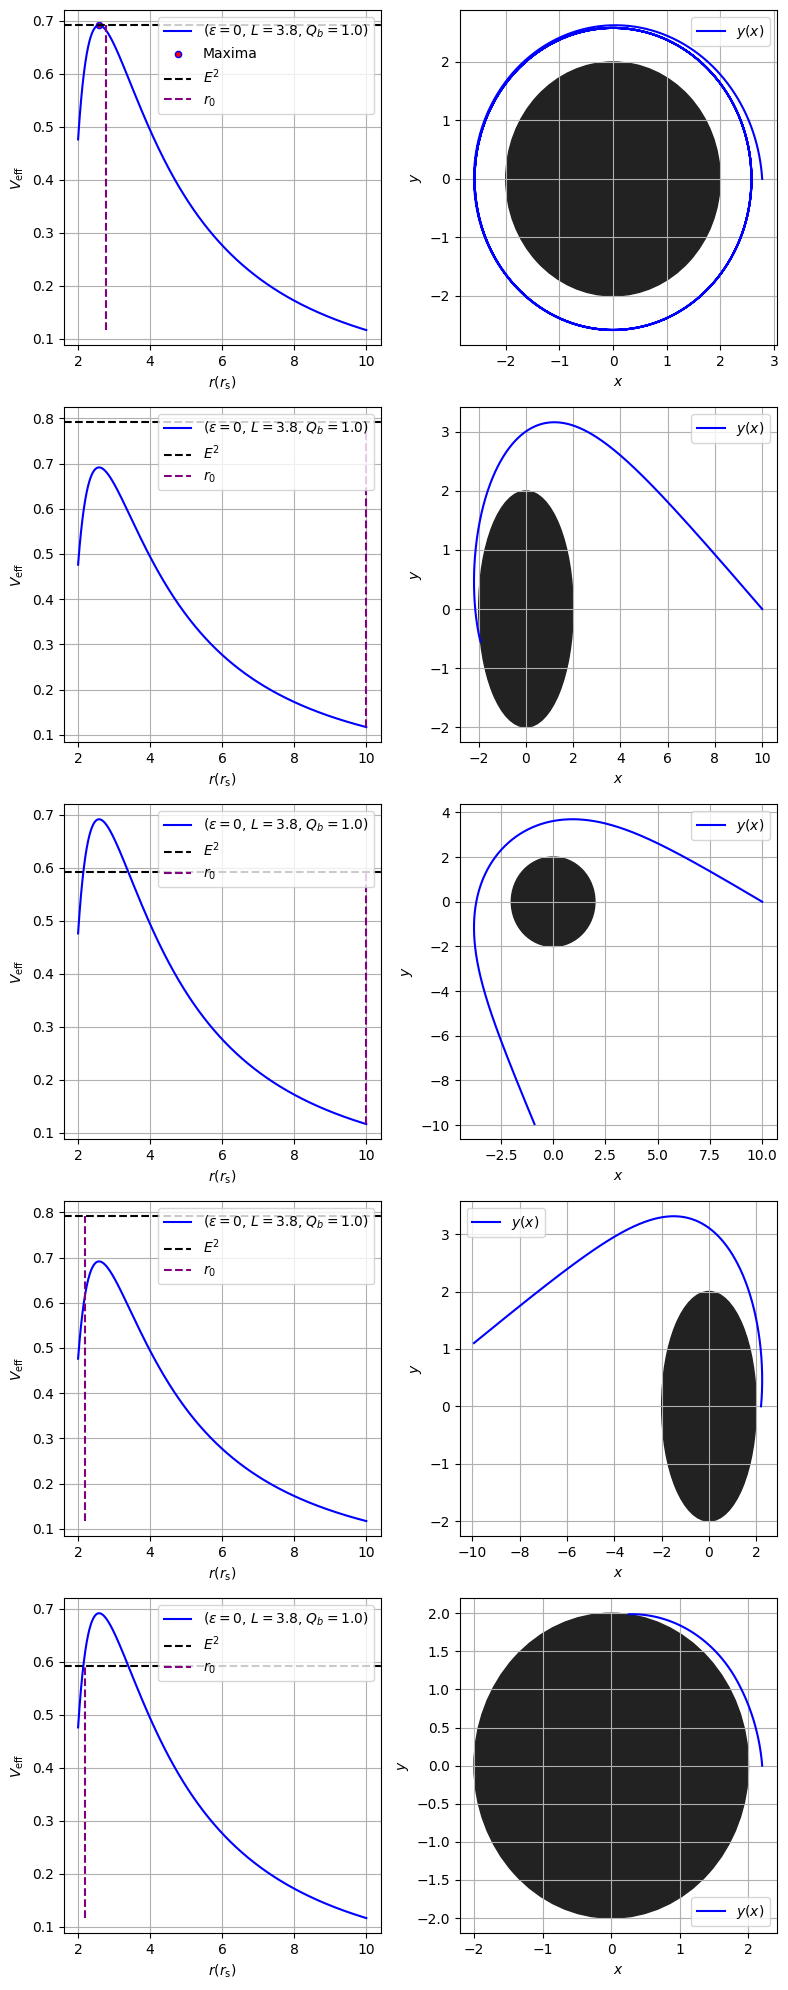

In [ ]:
# block 11 - create data for light trajectories 
# ------- with quantum corrections (Qb = 1.0) ------ #
Qb2 = float(extrema_array[12, 2])
r_circ3 = float(extrema_array[12, 0])
r_near3 = r_circ3 + 0.2
r_in3 = 2.2 * M1
E2_sq1 = float(extrema_array[12, 1]) #v_max (= E**2)
E2_1 = np.sqrt(E2_sq1)
#----------- circular orbit
params11 = (E2_1, L1, M1, Qb2, Qc0)

v_eff3 = np.array([v_eff(i, M1, L1, Qb2, Qc0, epsilon=0) for i in r_vals1])

t_vals_11, r_vals_11, phi_vals_11 = solve_geo2(r_near3, phi0, t0, lam_range_2, params11, epsilon=0)

# cartesian coordinates
x_vals_11 = r_vals_11 * np.cos(phi_vals_11)
y_vals_11 = r_vals_11 * np.sin(phi_vals_11)

#---------- E greater than circular -------------
E2_sq2 = E2_sq1 + 0.10
E2_2 = np.sqrt(E2_sq2)
params12 = (E2_2, L1, M1, Qb2, Qc0)

t_vals_12, r_vals_12, phi_vals_12 = solve_geo2(r0, phi0, t0, lam_range_2, params12, epsilon=0)

# cartesian coordinates
x_vals_12 = r_vals_12 * np.cos(phi_vals_12)
y_vals_12 = r_vals_12 * np.sin(phi_vals_12)

#---------- E less than circular -------------
E2_sq3 = E2_sq1 - 0.10
E2_3 = np.sqrt(E2_sq3)
params13 = (E2_3, L1, M1, Qb2, Qc0)

t_vals_13, r_vals_13, phi_vals_13 = solve_geo2(r0, phi0, t0, lam_range_2, params13, epsilon=0)

# cartesian coordinates
x_vals_13 = r_vals_13 * np.cos(phi_vals_13)
y_vals_13 = r_vals_13 * np.sin(phi_vals_13)

#---------- From inside - E greater than circular -------------
E2_sq4 = E2_sq1 + 0.10
E2_4 = np.sqrt(E2_sq4)
params14 = (E2_4, L1, M1, Qb2, Qc0)

t_vals_14, r_vals_14, phi_vals_14 = solve_geo2(r_in3, phi0, t0, lam_range_1, params14, epsilon=0, direction='outward')

# cartesian coordinates
x_vals_14 = r_vals_14 * np.cos(phi_vals_14)
y_vals_14 = r_vals_14 * np.sin(phi_vals_14)

#---------- From inside - E less than circular -------------
E2_sq5 = E2_sq1 - 0.10
E2_5 = np.sqrt(E2_sq5)
params15 = (E2_5, L1, M1, Qb2, Qc0)

t_vals_15, r_vals_15, phi_vals_15 = solve_geo2(r_in3, phi0, t0, lam_range_1, params15, epsilon=0)

# cartesian coordinates
x_vals_15 = r_vals_15 * np.cos(phi_vals_15)
y_vals_15 = r_vals_15 * np.sin(phi_vals_15)

In [ ]:
# block 12 - plot light trajectories - 5 initial conditions (r0, E)
# ------ quantum corrections (Qb = 1.0) -----#
fig, axes = plt.subplots(5, 2, figsize=(8, 20))

# First plot
axes[0, 0].plot(r_vals1, v_eff3, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb2}$)", color='b')
axes[0, 0].scatter(extrema_array[12,0], extrema_array[12, 1], color='r', s=20, edgecolors='b', label="Maxima")
axes[0, 0].axhline(y=E2_sq1, color='black', linestyle='--', label=r'$E^2$')
axes[0, 0].vlines(x=r_near3, ymin=min(v_eff3), ymax=E2_sq1, color='purple', linestyle='--', label=r'$r_0$')
axes[0, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[0, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[0, 0].legend()
axes[0, 0].grid()

# Second plot
axes[0, 1].plot(x_vals_11, y_vals_11, label=r'$y(x)$', color='blue')
circle_11 = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[0, 1].add_patch(circle_11)
axes[0, 1].set_xlabel(r'$x$')
axes[0, 1].set_ylabel(r'$y$')
axes[0, 1].legend()
axes[0, 1].grid()

# Third plot
axes[1, 0].plot(r_vals1, v_eff3, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb2}$)", color='b')
axes[1, 0].axhline(y=E2_sq2, color='black', linestyle='--', label=r'$E^2$')
axes[1, 0].vlines(x=r0, ymin=min(v_eff3), ymax=E2_sq2, color='purple', linestyle='--', label=r'$r_0$')
axes[1, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[1, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[1, 0].legend()
axes[1, 0].grid()

# Fourth plot
axes[1, 1].plot(x_vals_12, y_vals_12, label=r'$y(x)$', color='blue')
circle_12 = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[1, 1].add_patch(circle_12)
axes[1, 1].set_xlabel(r'$x$')
axes[1, 1].set_ylabel(r'$y$')
axes[1, 1].legend()
axes[1, 1].grid()

# Fifth plot
axes[2, 0].plot(r_vals1, v_eff3, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb2}$)", color='b')
axes[2, 0].axhline(y=E2_sq3, color='black', linestyle='--', label=r'$E^2$')
axes[2, 0].vlines(x=r0, ymin=min(v_eff3), ymax=E2_sq3, color='purple', linestyle='--', label=r'$r_0$')
axes[2, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[2, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[2, 0].legend()
axes[2, 0].grid()

# 6th plot
axes[2, 1].plot(x_vals_13, y_vals_13, label=r'$y(x)$', color='blue')
circle_13 = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[2, 1].add_patch(circle_13)
axes[2, 1].set_xlabel(r'$x$')
axes[2, 1].set_ylabel(r'$y$')
axes[2, 1].legend()
axes[2, 1].grid()

# 7th plot
axes[3, 0].plot(r_vals1, v_eff3, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb2}$)", color='b')
axes[3, 0].axhline(y=E2_sq4, color='black', linestyle='--', label=r'$E^2$')
axes[3, 0].vlines(x=r_in3, ymin=min(v_eff3), ymax=E2_sq4, color='purple', linestyle='--', label=r'$r_0$')
axes[3, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[3, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[3, 0].legend()
axes[3, 0].grid()

# 8th plot
axes[3, 1].plot(x_vals_14, y_vals_14, label=r'$y(x)$', color='blue')
circle_14 = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[3, 1].add_patch(circle_14)
axes[3, 1].set_xlabel(r'$x$')
axes[3, 1].set_ylabel(r'$y$')
axes[3, 1].legend()
axes[3, 1].grid()

# 9th plot
axes[4, 0].plot(r_vals1, v_eff3, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb2}$)", color='b')
axes[4, 0].axhline(y=E2_sq5, color='black', linestyle='--', label=r'$E^2$')
axes[4, 0].vlines(x=r_in3, ymin=min(v_eff3), ymax=E2_sq5, color='purple', linestyle='--', label=r'$r_0$')
axes[4, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[4, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[4, 0].legend()
axes[4, 0].grid()

# 10th plot
axes[4, 1].plot(x_vals_15, y_vals_15, label=r'$y(x)$', color='blue')
circle_15 = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[4, 1].add_patch(circle_15)
axes[4, 1].set_xlabel(r'$x$')
axes[4, 1].set_ylabel(r'$y$')
axes[4, 1].legend()
axes[4, 1].grid()

plt.tight_layout()
plt.show()